<a href="https://colab.research.google.com/github/SandroMiczevski/Music-Genre-Classifier/blob/main/Genre_Data_Preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

This project consists of classifying musical genres using the [GTZAN dataset](http://marsyas.info/downloads/datasets.html), which is a collection of 1000 songs of 30 second each, separated in 10 different musical genres. The songs were collected in 2000 - 2001 from a range of sources, and it was used to produce a well known paper about musical genre classification, [" Musical genre classification of audio signals " by G. Tzanetakis and P. Cook in IEEE Transactions on Audio and Speech Processing 2002.](https://ieeexplore.ieee.org/document/1021072)

The objective with this project is to apply two classification algorithms, K-Nearest Neigbors and Random Forest, to classify music genres. As result, is expected to have an accuracy and precision of over 60%.

# Data Preparation

### Libraries Import

Bellow you will find the installation command for the libraries used throughout this project, and their import.

In [ ]:
# !pip3 install python_speech_features
# !pip3 install scipy
# !pip3 install numpy
# !pip3 install matplotlib
# !pip3 install pandas
# !pip3 install pandas.compat
# !pip3 install librosa
!pip3 install seaborn

In [ ]:
# General libraries
import os
import math
import pickle
import random 
import operator
import IPython.display as ipd
from tempfile import TemporaryFile
import platform


# Data Analysis libraries
import numpy as np
import pandas as pd
import pandas.compat as pdc

from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing, metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt
import seaborn as sns


#Audio processing libraries
import librosa
import librosa.display
import scipy.io.wavfile as wav
from python_speech_features import mfcc

# from pandas.compat import StringIO

# Constants
_DEBUG_ = False
_CREATE_DATASET_ = False
_FRAME_SIZE_ = 1024
_HOP_LENGTH_ = 512

_OS_ = platform.system()

if (_OS_ == "Linux" or _OS_ == "Darwin"):
    directory = "/Users/sandro/Downloads/genres/"
    save_directory = "/Users/sandro/Downloads/"
else:
    directory = "D:/Sandro/Downloads/"
    save_directory = "D:/Sandro/Downloads/"


## Data Engineering Process

### Useful functions

This section is where some of the useful functions will be stored. These functions are used throughout the code to facilitate code readability and maintenance.

Here you will find these functions broken into the following sections:
* **Plotting**: Used to plot charts related to the data preparation part
* **Feature Extraction**: Used to extract information from the songs.

#### Plotting

In [ ]:
#Plotting Functions

def plot_spectral_centroid (data):
    time = librosa.frames_to_time( range(0, len(data)) )

    plt.figure(figsize=(20,8))
    plt.plot(time, data, color='r')

    plt.show()

def plot(data):
    length = data.shape[0]
    time = np.linspace(0., length, data.shape[0])

    plt.figure(figsize=(100,10))
    plt.plot(time, data, label="Left channel")
    plt.legend()
    plt.xlabel("Time [s]")
    plt.ylabel("Amplitude")
    plt.show()


def plot_comparision_graps (data = []):
    time = librosa.frames_to_time(range(len(d1)))

    for d in data:
        plt.figure(figsize=(20,8))
        plt.plot(time, d, color='darkblue', label="blues")
        plt.plot(time, d, color='grey', label="country")
        plt.plot(time, d, color='darkred', label="pop")
        plt.legend()
        plt.show()

### Feature Extraction

This section will contain a brief idea of what features we are going to extract from songs, and their importance for this project.

To ilustrate some of the concepts we are going to use a sound of a string being striked on a classic guitar

In [ ]:
# Interface that allow playing the audio

ipd.Audio(save_directory + "Roland-GR-1-Acoustic-Guitar-C4.wav")

In the code snipet bellow we are going to have the extraction of the data of the sound, as well as the sample rate at which it was recorded.

In [ ]:
guitar_data, guitar_sr = librosa.load(save_directory + "Roland-GR-1-Acoustic-Guitar-C4.wav")
audio_len = (guitar_data.shape[0])/guitar_sr

print(f"Sample Rate: {guitar_sr} KHz")
print(f"Audio length: {audio_len:.2f} seconds")

Sample Rate: 22050 KHz
Audio length: 3.01 seconds


* **2D Represantation of Waveform**: Is the graphic represantation of the shape of a signal that moves through gaseous, liquid, or solid medium [FADGI](https://www.digitizationguidelines.gov/term.php?term=waveformsound). The image bellow shows how the sound of the string behaves on a certain period of time.

<ipython-input-530-335dfa68dd84>:2: FutureWarning: Pass sr=22050 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(guitar_data, guitar_sr)


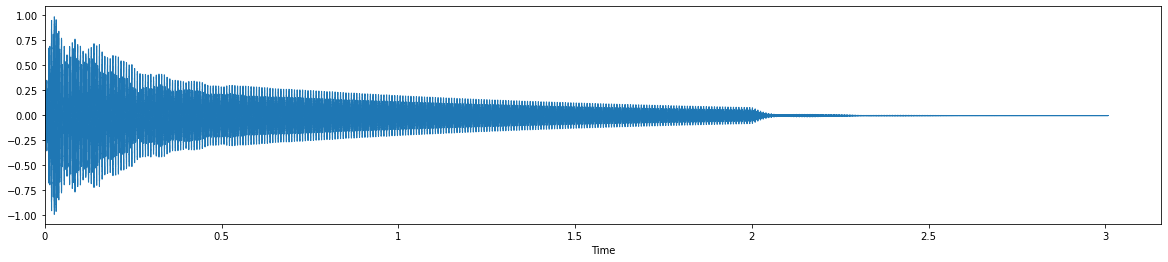

In [ ]:
plt.figure(figsize=(20,4))
librosa.display.waveshow(guitar_data, guitar_sr)
plt.xlim(0)
plt.show()

* **Fourier transform**: The Fourier Transformation will change the values on the x-axis from the time domain to the frequency-domain. This feature is relevant because it allows us to have a better understanding of the intensity of the frequencies in the analyzed song, therefore helping to identify different types of sound.


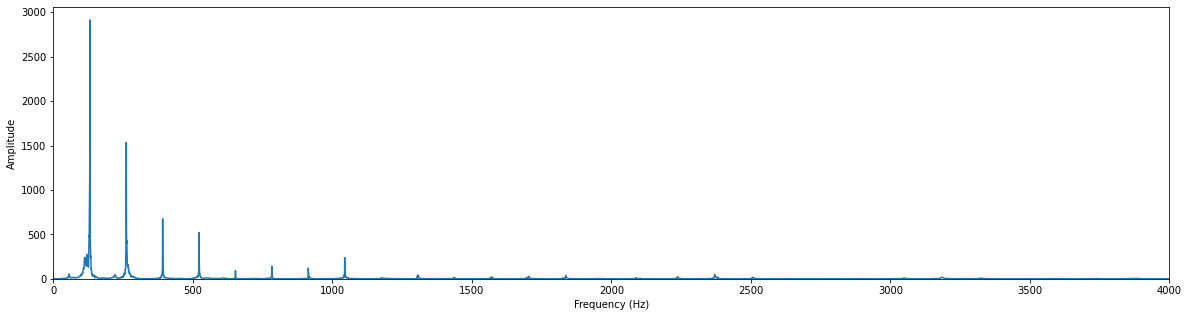

In [ ]:
fourier = np.abs(np.fft.fft(guitar_data))
freq = np.linspace(0, guitar_sr, len(fourier))

plt.figure(figsize=(20,5))
plt.plot(freq, fourier)
plt.ylim(0)
plt.ylabel("Amplitude")
plt.xlim([0,4000])
plt.xlabel("Frequency (Hz)")
plt.show()

* **Spectrogram**: A spectrogram is a visual representation of the frequencies of a signal, how they vary on time, and in what intesity. Spectrograms are used in fields of music, linguistics, and speech processing because it allows to identify phonems and different sounds. On the chart bellow you can notice the frequencies we have on the audio and their behavior along time, and, in addition to that, their intensity (in decibels), as shown on the scale at the righ-hand-side

(513, 130)
(513, 130)


/Users/sandro/Library/Python/3.8/lib/python/site-packages/librosa/util/decorators.py:88: UserWarning: power_to_db was called on complex input so phase information will be discarded. To suppress this warning, call power_to_db(np.abs(D)**2) instead.
  return f(*args, **kwargs)


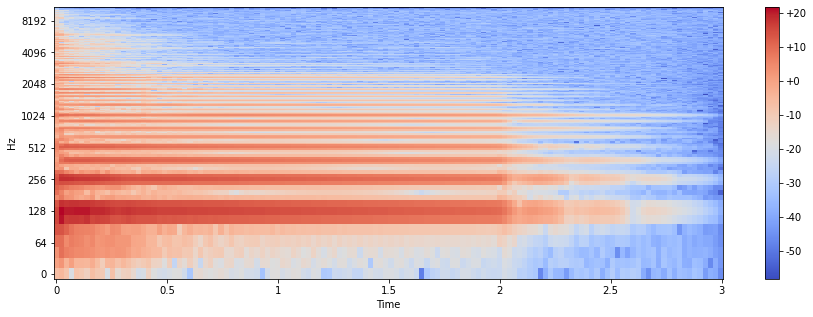

In [ ]:
## 
scale = librosa.stft(guitar_data, n_fft=_FRAME_SIZE_, hop_length=_HOP_LENGTH_)

print(scale.shape)
#type(scale[0][0])

Y_scale = np.abs(scale) ** 2
print(Y_scale.shape)

## We apply the logarithmic representation here to transform the power into decibels
## The redder a point on the chart is, more energy it represents at that time and frequency
Y_log_scale = librosa.power_to_db(scale)

plt.figure(figsize=(15,5))
librosa.display.specshow(Y_log_scale, sr = guitar_sr, hop_length=_HOP_LENGTH_, x_axis="time", y_axis="log")
plt.colorbar(format="%+2.f")

* **MEL Spectrograms**: Mel-Frequency Cepstrum, in basic terms, it is a transformation of the signal's frequency into a scale that is closer to what humans can perceive[[1]((https://towardsdatascience.com/getting-to-know-the-mel-spectrogram-31bca3e2d9d0))]. The application of this method, allow us to focus more on lower frquencies (which humans can understand), and reduce the presence of higher frequencies on the spectrum [[2](https://towardsdatascience.com/learning-from-audio-the-mel-scale-mel-spectrograms-and-mel-frequency-cepstral-coefficients-f5752b6324a8)]. The Mel Frequency Cepstral Coeficients (MFCCs) will be obtained after applying a cosine transformation over the MEL Spectrogram. [[3](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum)]





<ipython-input-541-c734a5dd3989>:4: FutureWarning: Pass y=[-8.7503780e-05 -2.3224848e-04 -4.9904536e-04 ...  5.0372756e-07
 -1.6152294e-06  0.0000000e+00] as keyword args. From version 0.10 passing these as positional arguments will result in an error
  mel_spectrogram = librosa.feature.melspectrogram(guitar_data, sr = guitar_sr, n_fft = _FRAME_SIZE_, hop_length=_HOP_LENGTH_, n_mels = _N_MELS_)


(30, 130)


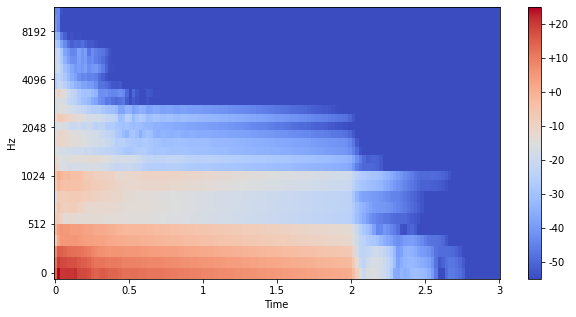

In [ ]:
## MEL SPECTROGRAMS
_N_MELS_ = 30

mel_spectrogram = librosa.feature.melspectrogram(guitar_data, sr = guitar_sr, n_fft = _FRAME_SIZE_, hop_length=_HOP_LENGTH_, n_mels = _N_MELS_)

log_mel_spectrogram = librosa.power_to_db(mel_spectrogram)
print(log_mel_spectrogram.shape)

plt.figure(figsize=(10,5))
librosa.display.specshow(log_mel_spectrogram, sr= guitar_sr, x_axis="time", y_axis="mel")
plt.colorbar(format="%+2.f")
plt.show()

### Function to create the dataset

This step will be used to create the data frame where all the features about the songs will be.
In this project we are going to be using three statistical measures (mean, median, standard-deviation) for the classification problems.

In [ ]:
def calulate_amplitude_envelope(data, frame_size = 1024, hop_size = 1024):
    ## Calculates the amplitude envelope, which would be the "silloutte" of the curves. 
    # If none of the parameters are informed, it will assume frame_size = 1024 and no hop_size.
    amplitude_envelope = []
    for i in range(0, len(data), hop_size):
        amplitude_envelope.append(  max(data[i:i+frame_size]) )
        
    return np.array(amplitude_envelope)

def extract_features (dataset, path, file_name, genre):
    ldata, lrate = librosa.load(path)

    # Spectral Feature
    amplitude_envelope = calulate_amplitude_envelope(ldata, _FRAME_SIZE_, _HOP_LENGTH_)

    rms = librosa.feature.rms(y = ldata, frame_length = _FRAME_SIZE_, hop_length = _HOP_LENGTH_)[0]
    
    zcr = librosa.feature.zero_crossing_rate(y = ldata, frame_length = _FRAME_SIZE_, hop_length = _HOP_LENGTH_)[0]

    spectral_centroid = librosa.feature.spectral_centroid(y = ldata, sr = lrate, n_fft = _FRAME_SIZE_, hop_length = _HOP_LENGTH_)[0]

    bandwidth = librosa.feature.spectral_bandwidth(y = ldata, sr = lrate, n_fft = _FRAME_SIZE_, hop_length = _HOP_LENGTH_)[0]

    np_fft = np.abs(np.fft.fft(ldata))

    # Rhythm features
    tempo = librosa.beat.tempo(ldata, sr = lrate, hop_length = _HOP_LENGTH_)[0]

    harmony = librosa.effects.harmonic(ldata, margin=2)

    # Feature manipulation

    ####### Extracting MFCCs #######
    mfccs = librosa.feature.mfcc(ldata, n_mfcc=13, sr = lrate)

    # Calculate derivatives, or delta and delta-delta
    delta_mfccs = librosa.feature.delta(mfccs)
    delta_mfccs2 = librosa.feature.delta(mfccs, order=2)

    # concatenate the mfcc and derivatives
    all_mfccs = np.concatenate((mfccs, delta_mfccs, delta_mfccs2))

    # calculate statistics for mfccs
    mfccs_mean = all_mfccs.mean(axis=1)
    mfccs_median = all_mfccs.std(axis=1)
    mfccs_std = all_mfccs.std(axis=1)

    ################################


    dataset.append({
            'file': file_name,
            
            # raw data
            # 'song_data': ldata,
            # 'sample_rate': lrate,

            # features extracted
            'amplitude_envelope_mean': np.mean(amplitude_envelope),
            'amplitude_envelope_median': np.median(amplitude_envelope),
            'amplitude_envelope_std': np.std(amplitude_envelope),
            
            'root_mean_square_mean': rms.mean(),
            'root_mean_square_median': np.median(rms),
            'root_mean_square_std': rms.std(),

            'zero_crossing_rate_mean': zcr.mean(),
            'zero_crossing_rate_median': np.median(zcr),
            'zero_crossing_rate_std': zcr.std(),

            'spectral_centroid_mean': spectral_centroid.mean(),
            'spectral_centroid_median': np.median(spectral_centroid),
            'spectral_centroid_var': spectral_centroid.std(),

            'bandwidth_mean': bandwidth.mean(),
            'bandwidth_median': np.median(bandwidth),
            'bandwidth_std': bandwidth.std(),

            'tempo': tempo,
            # 'tempo_median': np.median(tempo),
            # 'tempo_std': tempo.std(),
            
            'fourier_transform_mean': np_fft.mean(),
            'fourier_transform_median': np.median(np_fft),
            'fourier_transform_std': np_fft.std(),

            'harmony_mean': harmony.mean(),
            'harmony_median': np.median(harmony),
            'harmony_std': harmony.std(),

            'mfcc_mean_1': mfccs_mean[0],
            'mfcc_mean_2': mfccs_mean[1],
            'mfcc_mean_3': mfccs_mean[2],
            'mfcc_mean_4': mfccs_mean[3],
            'mfcc_mean_5': mfccs_mean[4],
            'mfcc_mean_6': mfccs_mean[5],
            'mfcc_mean_7': mfccs_mean[6],
            'mfcc_mean_8': mfccs_mean[7],
            'mfcc_mean_9': mfccs_mean[8],
            'mfcc_mean_10': mfccs_mean[9],
            'mfcc_mean_11': mfccs_mean[10],
            'mfcc_mean_12': mfccs_mean[11],
            'mfcc_mean_13': mfccs_mean[12],
            'mfcc_mean_14': mfccs_mean[13],
            'mfcc_mean_15': mfccs_mean[14],
            'mfcc_mean_16': mfccs_mean[15],
            'mfcc_mean_17': mfccs_mean[16],
            'mfcc_mean_18': mfccs_mean[17],
            'mfcc_mean_19': mfccs_mean[18],
            'mfcc_mean_10': mfccs_mean[19],
            'mfcc_mean_21': mfccs_mean[10],
            'mfcc_mean_22': mfccs_mean[21],
            'mfcc_mean_23': mfccs_mean[22],
            'mfcc_mean_24': mfccs_mean[23],
            'mfcc_mean_25': mfccs_mean[24],
            'mfcc_mean_26': mfccs_mean[25],
            'mfcc_mean_27': mfccs_mean[26],
            'mfcc_mean_28': mfccs_mean[27],
            'mfcc_mean_29': mfccs_mean[28],
            'mfcc_mean_30': mfccs_mean[29],
            'mfcc_mean_31': mfccs_mean[30],
            'mfcc_mean_32': mfccs_mean[31],
            'mfcc_mean_33': mfccs_mean[32],
            'mfcc_mean_34': mfccs_mean[33],
            'mfcc_mean_35': mfccs_mean[34],
            'mfcc_mean_36': mfccs_mean[35],
            'mfcc_mean_37': mfccs_mean[36],
            'mfcc_mean_38': mfccs_mean[37],
            'mfcc_mean_39': mfccs_mean[38],
            
            'mfcc_median_1': mfccs_median[0],
            'mfcc_median_2': mfccs_median[1],
            'mfcc_median_3': mfccs_median[2],
            'mfcc_median_4': mfccs_median[3],
            'mfcc_median_5': mfccs_median[4],
            'mfcc_median_6': mfccs_median[5],
            'mfcc_median_7': mfccs_median[6],
            'mfcc_median_8': mfccs_median[7],
            'mfcc_median_9': mfccs_median[8],
            'mfcc_median_10': mfccs_median[9],
            'mfcc_median_11': mfccs_median[10],
            'mfcc_median_12': mfccs_median[11],
            'mfcc_median_13': mfccs_median[12],
            'mfcc_median_14': mfccs_median[13],
            'mfcc_median_15': mfccs_median[14],
            'mfcc_median_16': mfccs_median[15],
            'mfcc_median_17': mfccs_median[16],
            'mfcc_median_18': mfccs_median[17],
            'mfcc_median_19': mfccs_median[18],
            'mfcc_median_10': mfccs_median[19],
            'mfcc_median_21': mfccs_median[10],
            'mfcc_median_22': mfccs_median[21],
            'mfcc_median_23': mfccs_median[22],
            'mfcc_median_24': mfccs_median[23],
            'mfcc_median_25': mfccs_median[24],
            'mfcc_median_26': mfccs_median[25],
            'mfcc_median_27': mfccs_median[26],
            'mfcc_median_28': mfccs_median[27],
            'mfcc_median_29': mfccs_median[28],
            'mfcc_median_30': mfccs_median[29],
            'mfcc_median_31': mfccs_median[30],
            'mfcc_median_32': mfccs_median[31],
            'mfcc_median_33': mfccs_median[32],
            'mfcc_median_34': mfccs_median[33],
            'mfcc_median_35': mfccs_median[34],
            'mfcc_median_36': mfccs_median[35],
            'mfcc_median_37': mfccs_median[36],
            'mfcc_median_38': mfccs_median[37],
            'mfcc_median_39': mfccs_median[38],

            'mfcc_std_1': mfccs_std[0],
            'mfcc_std_2': mfccs_std[1],
            'mfcc_std_3': mfccs_std[2],
            'mfcc_std_4': mfccs_std[3],
            'mfcc_std_5': mfccs_std[4],
            'mfcc_std_6': mfccs_std[5],
            'mfcc_std_7': mfccs_std[6],
            'mfcc_std_8': mfccs_std[7],
            'mfcc_std_9': mfccs_std[8],
            'mfcc_std_10': mfccs_std[9],
            'mfcc_std_11': mfccs_std[10],
            'mfcc_std_12': mfccs_std[11],
            'mfcc_std_13': mfccs_std[12],
            'mfcc_std_14': mfccs_std[13],
            'mfcc_std_15': mfccs_std[14],
            'mfcc_std_16': mfccs_std[15],
            'mfcc_std_17': mfccs_std[16],
            'mfcc_std_18': mfccs_std[17],
            'mfcc_std_19': mfccs_std[18],
            'mfcc_std_10': mfccs_std[19],
            'mfcc_std_21': mfccs_std[10],
            'mfcc_std_22': mfccs_std[21],
            'mfcc_std_23': mfccs_std[22],
            'mfcc_std_24': mfccs_std[23],
            'mfcc_std_25': mfccs_std[24],
            'mfcc_std_26': mfccs_std[25],
            'mfcc_std_27': mfccs_std[26],
            'mfcc_std_28': mfccs_std[27],
            'mfcc_std_29': mfccs_std[28],
            'mfcc_std_30': mfccs_std[29],
            'mfcc_std_31': mfccs_std[30],
            'mfcc_std_32': mfccs_std[31],
            'mfcc_std_33': mfccs_std[32],
            'mfcc_std_34': mfccs_std[33],
            'mfcc_std_35': mfccs_std[34],
            'mfcc_std_36': mfccs_std[35],
            'mfcc_std_37': mfccs_std[36],
            'mfcc_std_38': mfccs_std[37],
            'mfcc_std_39': mfccs_std[38],

            'genre': genre
        })

    return ldata, lrate 


Creating the dataset

In [ ]:
songs_data = []

i=0
if (_CREATE_DATASET_):
    for folder in os.listdir(directory):
        if(folder == '.DS_Store'):
            continue
        else:
            for file in os.listdir(directory +'/'+ folder): 
                tgt_file = directory + '/' + folder + "/" + file
                extract_features(songs_data, tgt_file, file, folder)

    df = pd.DataFrame(songs_data)
    print("Dataset created.")

    df.to_csv(save_directory + 'genre_dataset.csv')
    print("Dataset saved!")
else:
    print("Dataset creation is disabled.")

Dataset creation is disabled.


## Data Analysis

### Load the dataset and get an overall idea of the data

In this section we are going to have a glimpse of the data we are going to be working with.
Firstly, we are going to load the data saved during the previous step, and in the further steps we are going to extracts some statisctics of the data.

In [ ]:
data = pd.read_csv(directory + 'genre_dataset.csv')
data = data.iloc[:, 1:]

print("Done")
print(f"Data shape: {data.shape}")

Done
Data shape: (1000, 138)


In the code block above I am showing the size of the data we are going to be working with, so we have 139 dimensions, or features, and 1000 samples.

In the code block bellow, I am showing the first 3 rows of the data.

In [ ]:
data.head(3)

,file,amplitude_envelope_mean,amplitude_envelope_median,amplitude_envelope_std,root_mean_square_mean,root_mean_square_median,root_mean_square_std,zero_crossing_rate_mean,zero_crossing_rate_median,zero_crossing_rate_std,...,mfcc_std_31,mfcc_std_32,mfcc_std_33,mfcc_std_34,mfcc_std_35,mfcc_std_36,mfcc_std_37,mfcc_std_38,mfcc_std_39,genre
0,pop.00027.wav,0.435319,0.407562,0.180905,0.155133,0.145216,0.060121,0.101837,0.091797,0.061233,...,1.254927,1.286620,1.247836,1.238672,1.265668,1.055359,0.994447,1.009914,0.918609,pop
1,pop.00033.wav,0.407577,0.430450,0.155183,0.138845,0.150938,0.052949,0.136982,0.132812,0.055344,...,1.063226,1.042822,0.874764,0.796010,0.917812,0.779967,0.720536,0.712669,0.646347,pop
2,pop.00032.wav,0.282813,0.265747,0.137532,0.095698,0.085876,0.050663,0.228610,0.194336,0.151633,...,1.399974,1.352391,1.163117,1.272747,1.240867,0.950723,0.886321,0.794422,0.816807,pop


In the section bellow I am displaying a count of samples for every genre we are going to be working with. So, we have 100 samples for each of the 10 genres.

In [ ]:
data['genre'].value_counts()

disco        100
country      100
rock         100
metal        100
jazz         100
reggae       100
hiphop       100
pop          100
blues        100
classical    100
Name: genre, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Columns: 138 entries, file to genre
dtypes: float64(136), object(2)
memory usage: 1.1+ MB


The section bellow is showing us some statistics of the data.

In [ ]:
data.iloc[:,1:].describe()

,amplitude_envelope_mean,amplitude_envelope_median,amplitude_envelope_std,root_mean_square_mean,root_mean_square_median,root_mean_square_std,zero_crossing_rate_mean,zero_crossing_rate_median,zero_crossing_rate_std,spectral_centroid_mean,...,mfcc_std_30,mfcc_std_31,mfcc_std_32,mfcc_std_33,mfcc_std_34,mfcc_std_35,mfcc_std_36,mfcc_std_37,mfcc_std_38,mfcc_std_39
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,...,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,0.348947,0.333472,0.140800,0.128731,0.122059,0.053665,0.103601,0.093750,0.054587,2099.974150,...,1.334252,1.175518,1.075518,1.000031,0.925007,0.892063,0.864939,0.825765,0.798520,0.786038
std,0.172153,0.178622,0.061507,0.064540,0.064352,0.029609,0.041816,0.042241,0.026082,697.893022,...,0.444726,0.387372,0.338833,0.288486,0.247507,0.224698,0.210588,0.188542,0.173741,0.170207
min,0.012501,0.007904,0.007035,0.005260,0.003296,0.002198,0.021691,0.015625,0.007039,534.211575,...,0.472766,0.451476,0.460036,0.446528,0.438470,0.421886,0.385332,0.403930,0.410844,0.415117
25%,0.228984,0.207207,0.096607,0.084983,0.078295,0.034401,0.070226,0.061523,0.035771,1520.960195,...,1.014933,0.885744,0.822864,0.785796,0.744650,0.730562,0.722188,0.692647,0.678713,0.659093
50%,0.334691,0.314301,0.136660,0.119867,0.113475,0.048138,0.099473,0.089355,0.049468,2111.901420,...,1.264643,1.123187,1.040456,0.968131,0.889264,0.870591,0.840365,0.804245,0.774183,0.763051
75%,0.468181,0.446671,0.177824,0.172816,0.162166,0.065782,0.131909,0.123047,0.066533,2613.297084,...,1.606455,1.390891,1.284538,1.185262,1.080937,1.018639,0.989944,0.937547,0.905235,0.886641
max,0.911894,0.999725,0.331867,0.394145,0.407083,0.176120,0.274505,0.323242,0.186829,4172.053412,...,2.994025,3.192138,2.737061,2.211832,1.923765,1.754891,1.885830,1.622696,1.558513,1.498316


Using the boxplot we can have an idea of how we can differentiate genres using some of the features we have in the dataset. Some of the bundle of variables (mean, median, and standard deviation) that can be relevant, for modeling, are Amplitude Envelope, Root Mean Square, Zero Crossing Rate, and Spectral Centroid.

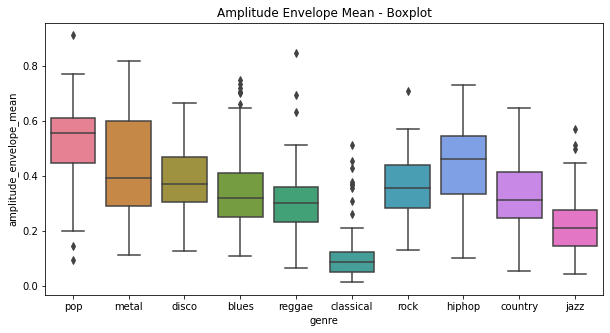

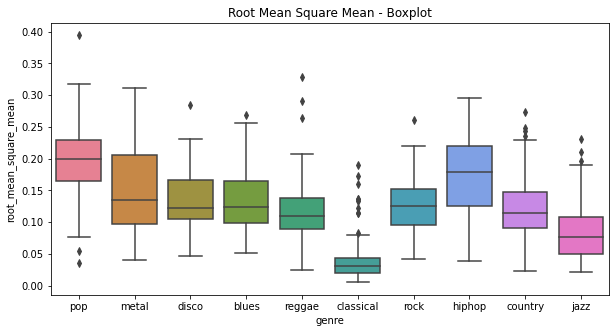

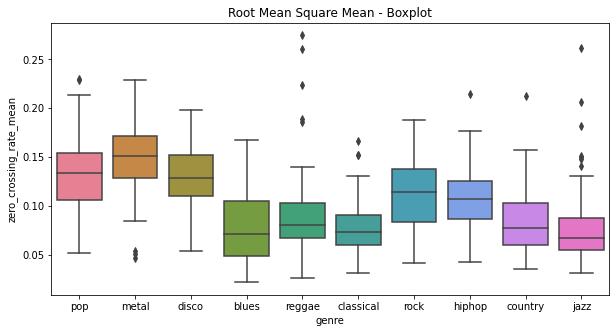

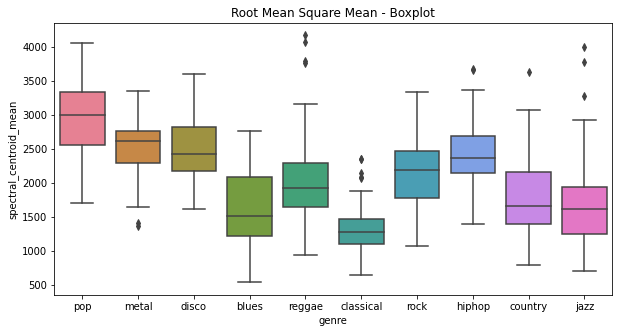

In [ ]:
plt.figure(figsize=(10,5))
sns.boxplot(x='genre', y='amplitude_envelope_mean', data = data, palette='husl')
plt.title("Amplitude Envelope Mean - Boxplot")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='genre', y='root_mean_square_mean', data = data, palette='husl')
plt.title("Root Mean Square Mean - Boxplot")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='genre', y='zero_crossing_rate_mean', data = data, palette='husl')
plt.title("Root Mean Square Mean - Boxplot")
plt.show()

plt.figure(figsize=(10,5))
sns.boxplot(x='genre', y='spectral_centroid_mean', data = data, palette='husl')
plt.title("Root Mean Square Mean - Boxplot")
plt.show()

Next we can plot a correlation matrix, to have an idea of how is the relationship between variables.
I have discarded the mfccs on the visualization for the sake of making it cleaner.

<ipython-input-44-022af0f909bd>:30: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(corr, dtype=np.bool))


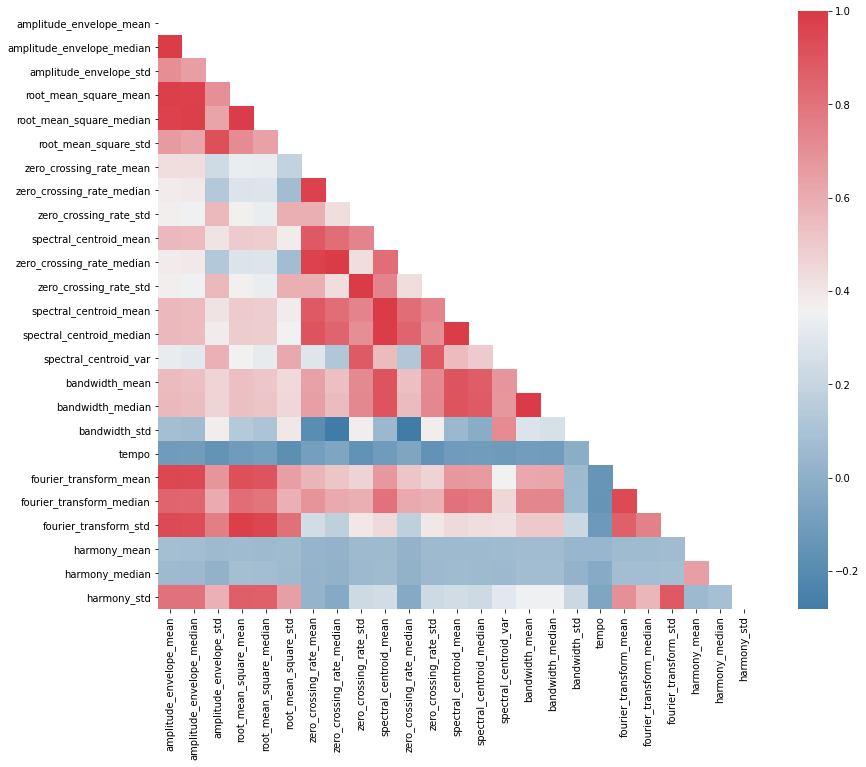

In [ ]:
variables = ['amplitude_envelope_mean',
                'amplitude_envelope_median',
                'amplitude_envelope_std',
                'root_mean_square_mean',
                'root_mean_square_median',
                'root_mean_square_std',
                'zero_crossing_rate_mean',
                'zero_crossing_rate_median',
                'zero_crossing_rate_std',
                'spectral_centroid_mean',
                'zero_crossing_rate_median',
                'zero_crossing_rate_std',
                'spectral_centroid_mean',
                'spectral_centroid_median',
                'spectral_centroid_var',
                'bandwidth_mean',
                'bandwidth_median',
                'bandwidth_std',
                'tempo',
                'fourier_transform_mean',
                'fourier_transform_median',
                'fourier_transform_std',
                'harmony_mean',
                'harmony_median',
                'harmony_std']

corr = data[variables].corr()

# Creating a mask to remove repeated clusters on the heatmap
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Create a color palette to apply to the heatmap
cmap = sns.diverging_palette(240, 10, n = 5, as_cmap=True)

# Create the graph
plt.figure(figsize=(15,11))
sns.heatmap(corr, mask=mask, cmap=cmap, square=True)
plt.show()


A few variables show a high correlation, as amplitude envelope is highly correlated with root-mean-square and the fourier transform. In addition, zero-crossing rate is correlated with spectral-centroid and bandwidth. 

# Data Modeling

## Data Preparation

A few of the steps taken here are the following:

* Normalization
* Pricipal Component Analysis
* Split the Dataset' 

In [ ]:
Y = data.genre
X = data.drop(['file', 'genre'], axis=1)

print(f"Shapes: data = {data.shape}, X = {X.shape}, Y = {Y.shape}")

Shapes: data = (1000, 138), X = (1000, 136), Y = (1000,)


### Normalizing the X dataset

In [ ]:
cols = X.columns

min_max = preprocessing.MinMaxScaler()
X_transformed = min_max.fit_transform(X)

X_norm = pd.DataFrame(X_transformed, columns= cols)
X_norm.shape

(1000, 136)

### Splitting the Dataset

In [ ]:
# Splitting the data 
X_tr, X_va, Y_tr, Y_va = train_test_split(X_norm, Y, test_size=0.2)
print ('shape input : ', np.shape(X_norm))
print ('shape target : ', np.shape(Y))
print('----------------')
print ('shape inp_tr, tar_tr (trining set (input and target, respectively) : ', np.shape(X_tr),np.shape(Y_tr))
print ('shape inp_va, tar_va (Validation set (input and target, respectively) : ', np.shape(X_va),np.shape(Y_va))
print()


shape input :  (1000, 136)
shape target :  (1000,)
----------------
shape inp_tr, tar_tr (trining set (input and target, respectively) :  (800, 136) (800,)
shape inp_va, tar_va (Validation set (input and target, respectively) :  (200, 136) (200,)



### Plotting the distribution of the target variable, for training and validation sets.

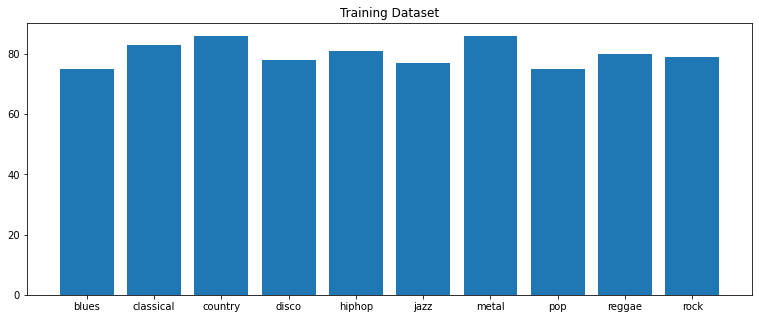

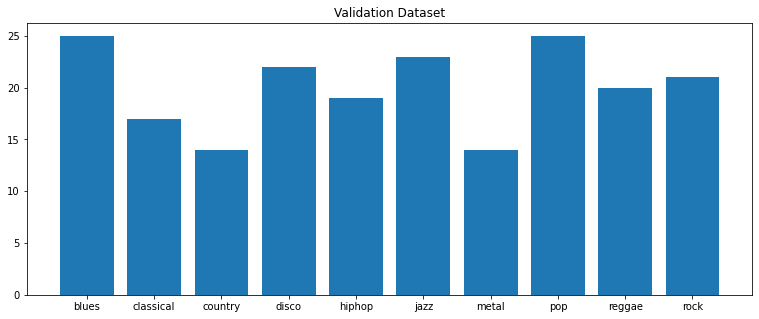

In [ ]:
tr = pd.DataFrame(Y_tr.value_counts()).sort_index(ascending=True)
va = pd.DataFrame(Y_va.value_counts()).sort_index(ascending=True)

plt.figure(figsize=(13,5))
plt.title("Training Dataset")
plt.bar(x=tr.index, height=tr.genre.values)
plt.show()

plt.figure(figsize=(13,5))
plt.title("Validation Dataset")
plt.bar(x=va.index, height=va.genre.values)
plt.show()

## Applying K-Nearest Neighbors

In [ ]:
def  apply_knn_model(X_tr, X_va, Y_tr, Y_va, neighbors):
    knn = KNeighborsClassifier(n_neighbors=neighbors)

    knn.fit(X_tr, Y_tr)

    Y_tr_pred= knn.predict(X_tr)
    Y_va_pred= knn.predict(X_va)
    
    cm_tr = confusion_matrix(Y_tr, Y_tr_pred, labels=knn.classes_)
    cm_pred = confusion_matrix(Y_va, Y_va_pred, labels=knn.classes_)

    Y_tr_prob= knn.predict_proba(X_tr)[:,1]
    Y_va_prob= knn.predict_proba(X_va)[:,1]

    print(f"Probabilities Shapes: training prediction {Y_tr_prob.shape}, validation prediction {Y_va_prob.shape}")
    print(f"Prediction Shapes: training prediction {Y_tr_pred.shape}, validation prediction {Y_va_pred.shape}")

    # Plotting comparision graphs

    plt.figure(figsize=(12,4))
    plt.hist(Y_tr_pred, 20, label="Predicted", color = "b", histtype='step')
    plt.hist(Y_tr, 20, label="Real", color = "black", histtype='step')
    plt.title('Comparing results')
    plt.ylabel('N')
    plt.legend()
    plt.show()

    print ("--------------------------")
    print (f"Recall (TR) =  {metrics.recall_score(Y_tr, Y_tr_pred, average='macro'):.2f}")
    print (f"Recall (VA) =  {metrics.recall_score(Y_va, Y_va_pred, average='macro'):.2f}")
    print ("--------------------------")
    print (f"Accuracy (TR) =  {metrics.accuracy_score(Y_tr, Y_tr_pred):.2f}")
    print (f"Accuracy (VA) =  {metrics.accuracy_score(Y_va, Y_va_pred):.2f}")
    print ("--------------------------")
    print (f"Precision (TR) = {metrics.precision_score(Y_tr, Y_tr_pred, average='macro'):.2f}")
    print (f"Precision (VA) =  {metrics.precision_score(Y_va, Y_va_pred, average='macro'):.2f}")
    print ("--------------------------")

    print("TRAINING DATASET")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_tr, display_labels=knn.classes_)
    disp.plot(xticks_rotation='vertical')

    print("VALIDATION DATASET")
    disp = ConfusionMatrixDisplay(confusion_matrix=cm_pred, display_labels=knn.classes_)
    disp.plot(xticks_rotation='vertical')
    
    return Y_tr_pred, Y_va_pred, Y_tr_prob, Y_va_prob


Probabilities Shapes: training prediction (800,), validation prediction (200,)
Prediction Shapes: training prediction (800,), validation prediction (200,)


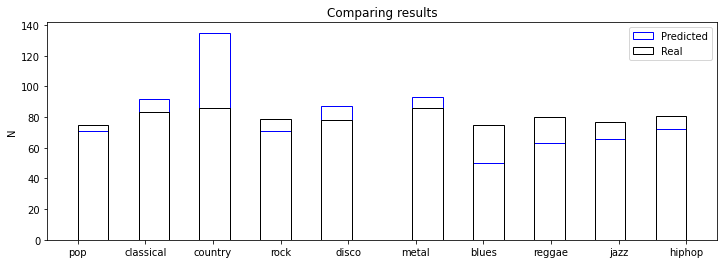

--------------------------
Recall (TR) =  0.70
Recall (VA) =  0.67
--------------------------
Accuracy (TR) =  0.70
Accuracy (VA) =  0.65
--------------------------
Precision (TR) = 0.72
Precision (VA) =  0.69
--------------------------
TRAINING DATASET
VALIDATION DATASET


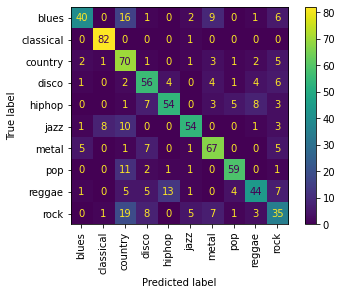

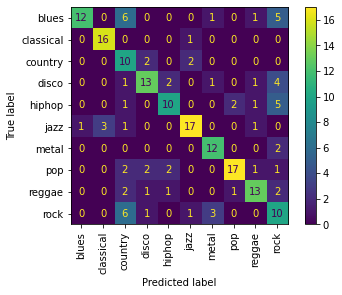

In [ ]:
knn_y_tr_pred, knn_y_va_pred, _, _ = apply_knn_model(X_tr, X_va, Y_tr, Y_va, 13)

KNN presented a good result, on the validation dataset: 69% precision, 65% Accuracy, and 67% Recall rate.

## Applying Random Forest

In [ ]:
def plot_comparision (Y_tr, Y_tr_pred,):
    plt.figure(figsize=(15,5))
    plt.hist(Y_tr_pred, 20, label="Predicted", color = "b", histtype='step')
    plt.hist(Y_tr, 20, label="Real", color = "black", histtype='step')
    plt.title('Comparing results')
    plt.ylabel('N')
    plt.legend()
    plt.show()

def confusion_matrix_plot(classifier, Y, prediction, msg = ""):
    print(msg)
    cm = confusion_matrix(Y, prediction, labels=classifier.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classifier.classes_)
    disp.plot(xticks_rotation='vertical')

In [ ]:
def apply_random_trees(X_tr, X_va, Y_tr, Y_va, estimators, print_scores=False):
    clf = ExtraTreesClassifier( n_estimators=estimators,  
                                max_leaf_nodes=188,
                                max_features='auto', 
                                min_samples_split=2, 
                                random_state=0,
                                n_jobs = -1)
    clf = clf.fit(X_tr, Y_tr)

    tr_prediction = clf.predict(X_tr)
    va_prediction = clf.predict(X_va)

    tr_precision = metrics.precision_score(Y_tr, tr_prediction, average='macro')
    va_precision = metrics.precision_score(Y_va, va_prediction, average='macro')

    if (print_scores):
        plot_comparision (Y_tr, tr_prediction)

        print(tr_prediction.shape)
        print(va_prediction.shape)

        print ("--------------------------")
        print (f"Recall (TR) = {(metrics.recall_score(Y_tr, tr_prediction, average='macro')*100):.2f}%")
        print (f"Recall (VA) = {(metrics.recall_score(Y_va, va_prediction, average='macro')*100):.2f}%")
        print ("--------------------------")
        print (f"Accuracy (TR) = {(metrics.accuracy_score(Y_tr, tr_prediction)*100):.2f}%")
        print (f"Accuracy (VA) = {(metrics.accuracy_score(Y_va, va_prediction)*100):.2f}%")
        print ("--------------------------")
        print (f"Precision (TR) = {(tr_precision)*100:.2f}%")
        print (f"Precision (VA) = {(va_precision)*100:.2f}%")
        print ("--------------------------")

        confusion_matrix_plot(clf, Y_tr, tr_prediction, "TRAINING DATASET")
        confusion_matrix_plot(clf, Y_va, va_prediction, "VALIDATION DATASET")

    return tr_prediction, va_prediction, va_precision, tr_precision, clf

In [ ]:
estimators = []

validation_precision_score = []
train_precision_score = []

for i in range(50, 400, 3):
    _, _, validation_precision, train_precision, _ = apply_random_trees(X_tr, X_va, Y_tr, Y_va, i)

    validation_precision_score.append(validation_precision)
    train_precision_score.append(train_precision)
    estimators.append(i)


Testing what would be the # of estimators that would achieve a higher precision rate

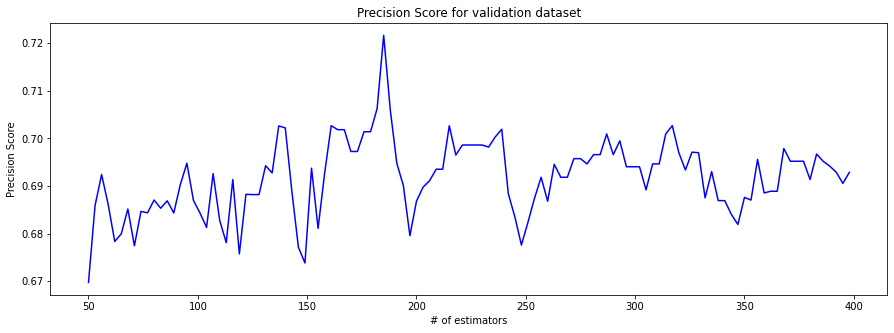

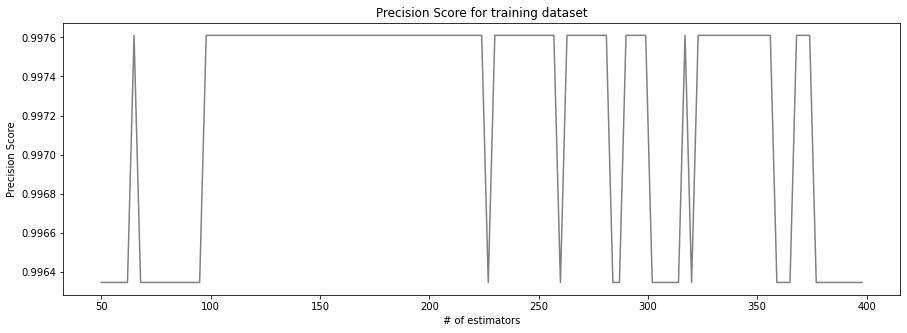

Narrowing down the chart


Text(0, 0.5, 'Precision Score')

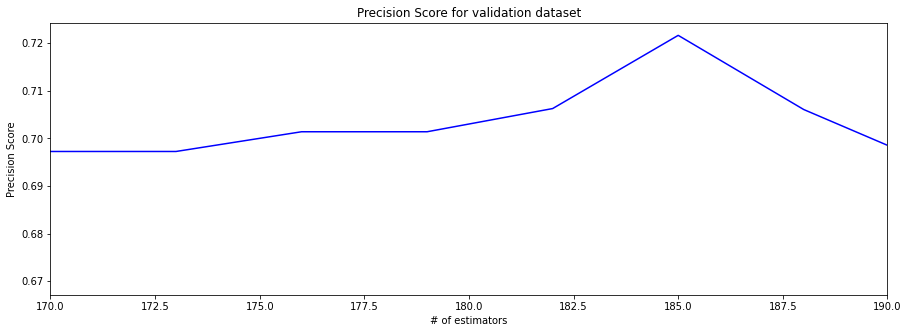

In [ ]:
plt.figure(1, figsize=(15,5))
plt.plot(estimators, validation_precision_score, color='blue', label="Validation")
plt.title("Precision Score for validation dataset")
plt.xlabel("# of estimators")
plt.ylabel("Precision Score")


plt.figure(2, figsize=(15,5))
plt.plot(estimators, train_precision_score, color='grey', label="Train")
plt.title("Precision Score for training dataset")
plt.xlabel("# of estimators")
plt.ylabel("Precision Score")
plt.show()

print("Narrowing down the chart")

plt.figure(1, figsize=(15,5))
plt.plot(estimators, validation_precision_score, color='blue', label="Validation")
plt.xlim([170,190])
plt.title("Precision Score for validation dataset")
plt.xlabel("# of estimators")
plt.ylabel("Precision Score")

Found that 185 different trees would get the highest precision. Next, applyin the # of estimators that gives us the best precision rate found, so far.

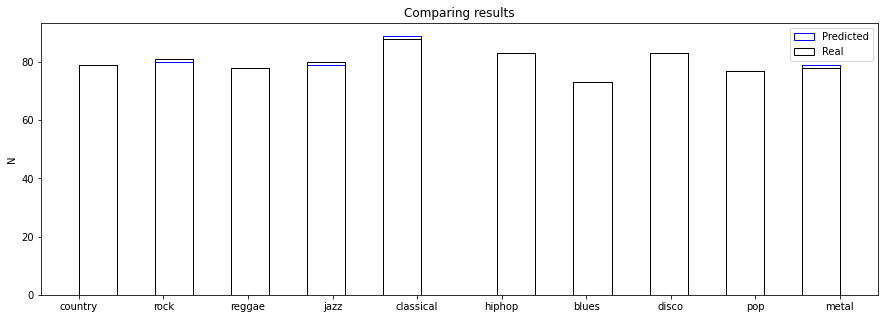

(800,)
(200,)
--------------------------
Recall (TR) = 99.75%
Recall (VA) = 72.31%
--------------------------
Accuracy (TR) = 99.75%
Accuracy (VA) = 70.50%
--------------------------
Precision (TR) = 99.76%
Precision (VA) = 72.17%
--------------------------
TRAINING DATASET
VALIDATION DATASET


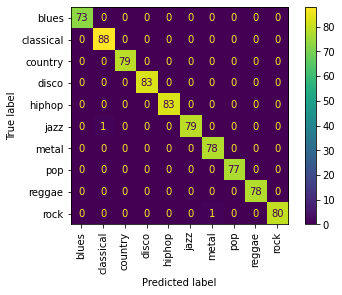

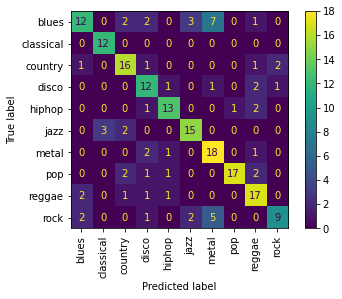

In [ ]:
tr_prediction, va_prediction, _, _, rf = apply_random_trees(  X_tr, X_va, 
                                                    Y_tr, Y_va, 
                                                    estimators=185, 
                                                    print_scores=True)

The Random Forest model presented good results as well, on the validation dataset: Precision 72.2%, Accuracy 70.5%, and Recall 72.3%.

One difference that the Random Forest showed, when compared to KNN, is that some errors were closer to reality than KNN. An example of that is 5 rock songs were predicted as metal, 3 jazz songs predicted as classical music.

# Conclusion

Both classification methods had acceptable results, as I was aiming at at precision and accuracy ov over 60%. However the Random Forest algorithm performed considerably better than the KNN. One change that can be made here to improve the quality of these classification models is to review and get better data, focusing on features that can better describe musical genres.

# Other References


[1]. [ANDRADA OLTEANU - Kaggle - Guide through the features extraction](https://www.kaggle.com/code/andradaolteanu/work-w-audio-data-visualise-classify-recommend/notebook)

[2]. [Valerio Velardo - Youtube - Audio Signal Processing for Machine Learning](https://www.youtube.com/playlist?list=PL-wATfeyAMNqIee7cH3q1bh4QJFAaeNv0)

[3]. [Data-Flair - website - Python Project - Music Genre Classification](https://data-flair.training/blogs/python-project-music-genre-classification/)

[4]. [GitHub](https://github.com/musikalkemist/AudioSignalProcessingForML)

[5]. [Sci Kit Learn - Random Forest](https://scikit-learn.org/stable/modules/ensemble.html#forest)

#### Other data

[Free loops](https://free-loops.com/1569-12-string-guitar-e.html)

[Free Wave Samples](https://freewavesamples.com/roland-gr1-acoustic-guitar-c4)